In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

seed = 137

# Data

This dataset was collected by the Cook County Assessor's Office in order to build a model to predict the monetary value of a home. The dataset consists of over 200K records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is sales price. Some of the columns have been pre-filtered out for the project.  


In [2]:
# Loading data
data_path = "../data/"
data = pd.read_csv(data_path+"cook_county.csv", index_col='Unnamed: 0')

# Sanity check
assert data.shape == (204792, 62)
assert 'Sale Price' in data.columns.values
data.head(3)

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204792 entries, 0 to 204791
Data columns (total 62 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   PIN                         204792 non-null  int64  
 1   Property Class              204792 non-null  int64  
 2   Neighborhood Code           204792 non-null  int64  
 3   Land Square Feet            204792 non-null  float64
 4   Town Code                   204792 non-null  int64  
 5   Apartments                  204792 non-null  float64
 6   Wall Material               204792 non-null  float64
 7   Roof Material               204792 non-null  float64
 8   Basement                    204792 non-null  float64
 9   Basement Finish             204792 non-null  float64
 10  Central Heating             204792 non-null  float64
 11  Other Heating               204792 non-null  float64
 12  Central Air                 204792 non-null  float64
 13  Fireplaces         

In [4]:
# Data imputation
data.isnull().sum().any() ##check for null

False

# EDA

Examine the distribution of our target variable `Sale Price`. At the same time, we also take a look at some descriptive statistics of this variable. 

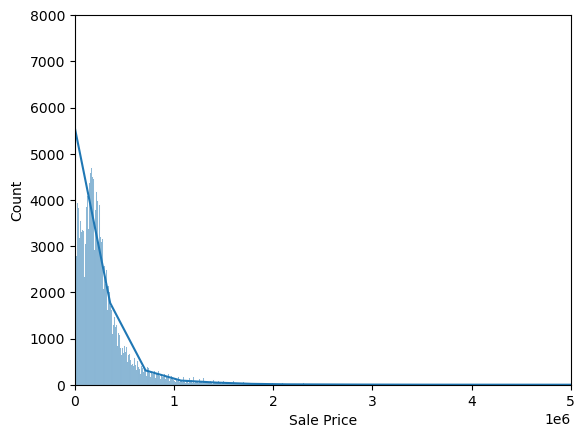

In [5]:
sns.histplot(data['Sale Price'], kde=True)
plt.xlim(left=0, right=5000000)
plt.ylim(top=8000)
plt.show()

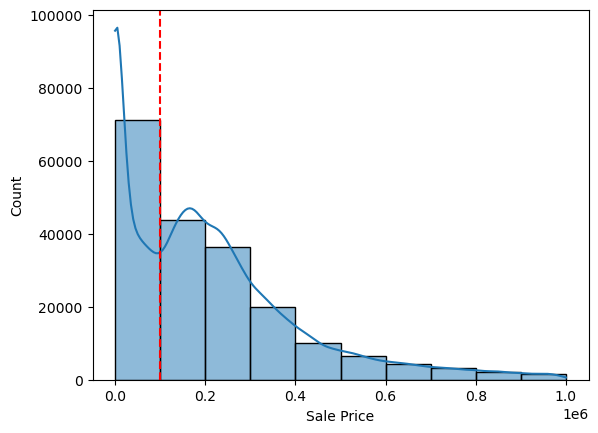

In [6]:
sns.histplot(data[data['Sale Price']<1000000]['Sale Price'], bins=10, kde=True)
plt.axvline(x=100000, color='r', linestyle='--')
plt.show()

Sale price distribution is right skewed, with a spike of outlying property price of under 100K.

Add log sale price to examine distribution and pattern to other attributes.

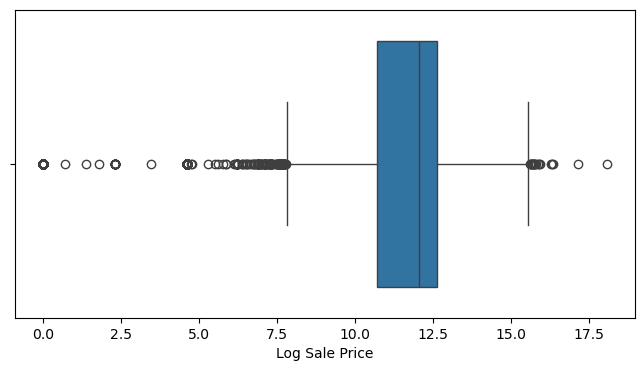

In [7]:
data['Log Sale Price'] = np.log(data['Sale Price'])
plt.figure(figsize=(8, 4))
sns.boxplot(data['Log Sale Price'], orient='h')
plt.show()

Check for feature correlations to `Sale Price`. Identify useful features or possible feature engineering.

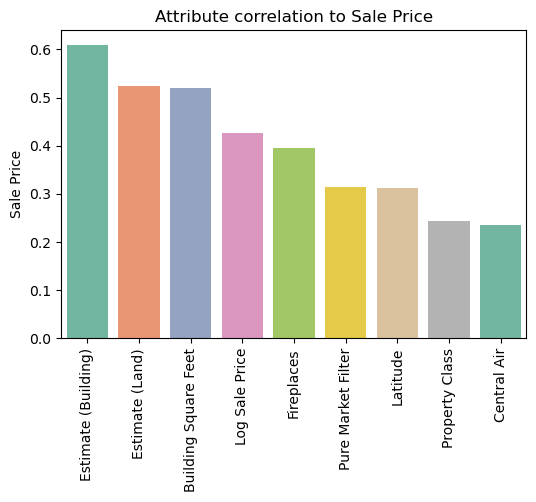

In [8]:
cor_data = data[['Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year',
       'Sale Month of Year', 'Sale Half of Year', 'Most Recent Sale',
       'Age Decade', 'Pure Market Filter', 'Garage Indicator',
       'Neigborhood Code (mapping)', 'Town and Neighborhood',
       'Lot Size', 'Log Sale Price']]
plt.figure(figsize=(6, 4))
sns.barplot(cor_data.corr()['Sale Price'].sort_values(ascending=False)[1:10], palette='Set2')
plt.xticks(rotation=90)
plt.title("Attribute correlation to Sale Price")
plt.show()

Next we explore additional features extracted from data.

1. **Bedroom Counts**

In [9]:
def add_total_bedrooms(data):
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(r"(\d+)(\s?\w+){1,3} bedroom")[0].astype(int)
    return with_rooms

data_copy = add_total_bedrooms(data)

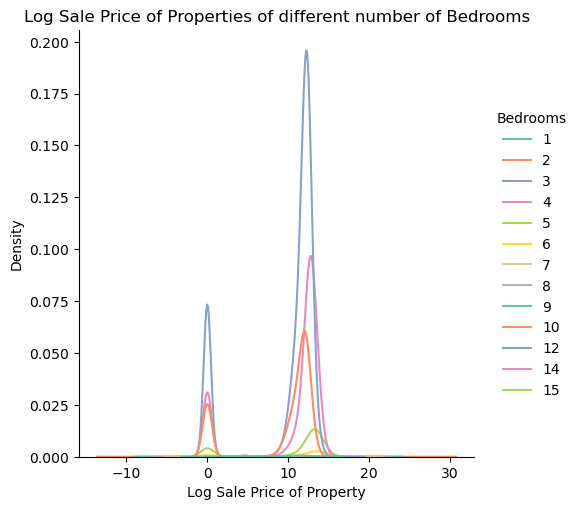

In [10]:
sns.displot(data = data_copy[['Bedrooms', 'Log Sale Price']], 
            x = 'Log Sale Price', 
            kind = 'kde', 
            hue = 'Bedrooms', 
            palette = 'Set2')
plt.xlabel('Log Sale Price of Property')
plt.title('Log Sale Price of Properties of different number of Bedrooms')
plt.show()

In [11]:
data_copy[['Sale Price', 'Bedrooms']].corr()['Sale Price']

Sale Price    1.000000
Bedrooms      0.350507
Name: Sale Price, dtype: float64

2. **Neighborhood**

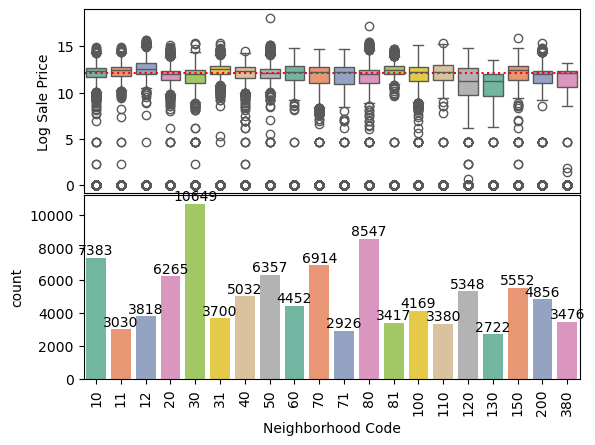

In [12]:
top_20_neighborhoods = data[data['Neighborhood Code'].isin(data['Neighborhood Code'].value_counts().iloc[0:20].index)]

fig, axs = plt.subplots(nrows=2)

sns.boxplot(x='Neighborhood Code', y='Log Sale Price', data=top_20_neighborhoods, ax=axs[0], palette = 'Set2')
sns.countplot(x='Neighborhood Code', data=top_20_neighborhoods, ax=axs[1], palette = 'Set2')

# Draw median price
axs[0].axhline(y=data['Log Sale Price'].median(), color='red',linestyle='dotted')

# Format and label
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)
plt.subplots_adjust(hspace=0.01)
plt.show()

In [13]:
data_copy = data.copy()
data_copy['High Price Neighborhood'] = data_copy['PIN'].isin(top_20_neighborhoods['PIN']).astype(int)
data_copy[['Sale Price', 'High Price Neighborhood']].corr()['Sale Price']

Sale Price                 1.0000
High Price Neighborhood    0.0155
Name: Sale Price, dtype: float64

# Model

## Data Processing

Prepare data for modeling.

- Replace NULLs with median
- Extract numerical information from `Description` string, and drop `Description`
- All data entries are under `Modeling Group` SF, so drop `Modeling Group`
- Feature engineering
- Remove outliers

In [14]:
def replace_null_with_med(series):
    replace_with = series.median()
    series[series.isna()] = replace_with
    series.replace(to_replace = 0, value = replace_with, inplace = True)
    
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    return data[(data[variable] > lower) & (data[variable] <= upper)]

In [15]:
# Extract useful information from Description
def add_bathrooms(data):
    data['Bathrooms'] = data['Description'].str.extract(r'(\d\.\d) of which are bathrooms').astype(float)
    
def add_rooms(data):
    data['Rooms'] = data['Description'].str.extract(r'(\d+) rooms').astype(int)
    
# Other useful features
def log_building_sqft(data):
    replace_null_with_med(data['Building Square Feet'])
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    
def log_land_sqft(data):
    replace_null_with_med(data['Land Square Feet'])
    data['Log Land Square Feet'] = np.log(data['Land Square Feet'])

def log_estimate_building(data):
    replace_null_with_med(data['Estimate (Building)'])
    data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'])

def log_estimate_land(data):
    replace_null_with_med(data['Estimate (Land)'])
    data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'])
    
def log_sale_price(data):
    replace_null_with_med(data['Sale Price'])
    data['Log Sale Price'] = np.log(data['Sale Price'])

In [16]:
# Additional helper func
def select_columns(data, *columns):
    return data.loc[:, columns]

## Data Pipeline

In [17]:
def process_data_fm(data):
    
    log_sale_price(data)
    log_building_sqft(data)
    log_land_sqft(data)
    log_estimate_building(data)
    log_estimate_land(data)
    add_bathrooms(data)
    add_rooms(data)
    data = remove_outliers(data, 'Log Sale Price', lower=4.99, upper=16)
    data = remove_outliers(data, 'Log Estimate (Building)', lower=6.59)
    data = remove_outliers(data, 'Log Estimate (Land)', lower=6.59)
    data = remove_outliers(data, 'Bathrooms', lower=0.4)
        
    data = select_columns(data, 
                       'Estimate (Building)', 'Estimate (Land)', 'Pure Market Filter', 
                       'Log Estimate (Building)', 'Log Estimate (Land)', 'Log Building Square Feet', 'Building Square Feet', 
                       'Latitude', 
                       'Bathrooms', 'Rooms', 'Fireplaces', 'Central Air', 
                       'Sale Price'
                      )
    return data

## Train
We train on different models including linear regression, ridge regression, and random forest regression.

In [18]:
data = pd.read_csv(data_path+"cook_county.csv", index_col='Unnamed: 0')
data = process_data_fm(data)
X_train, X_test, y_train, y_test = train_test_split(data.drop('Sale Price',axis=1), data['Sale Price'], test_size=0.2, random_state=seed)

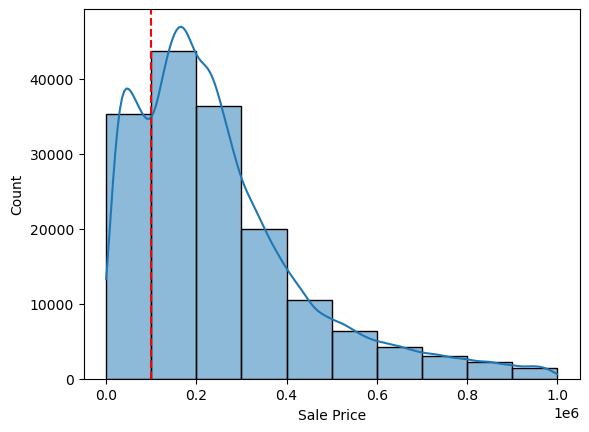

In [29]:
sns.histplot(data[data['Sale Price']<1000000]['Sale Price'], bins=10, kde=True)
plt.axvline(x=100000, color='r', linestyle='--')
plt.show()

1. **Linear Regression**

In [45]:
input = [('scale', StandardScaler())
         , ('polynomial', PolynomialFeatures(degree=2))
         , ('model',LinearRegression())
        ]
linear = Pipeline(input)
linear

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('model', LinearRegression())])

In [46]:
# Train
linear.fit(X_train, y_train)
linear.score(X_test, y_test)

0.7779968238189358

In [47]:
# Test
linear_pred = linear.predict(X_test)
r2_score(y_test, linear_pred)

0.7779968238189358

2. **Ridge Regression**

In [39]:
ridge = Ridge(alpha = 0.001)
ridge

Ridge(alpha=0.001)

In [40]:
# Train
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.7209938115746456

In [41]:
# Test
ridge_pred = ridge.predict(X_test)
r2_score(y_test, ridge_pred)

0.7209938115746456

3. **Random Forest Regression**

In [25]:
regressor = RandomForestRegressor(n_estimators=100, random_state=seed)
regressor

RandomForestRegressor(random_state=137)

In [26]:
# Train
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.8089679571800971

In [27]:
# Test
regressor_pred = regressor.predict(X_test)
r2_score(y_test, regressor_pred)

0.8089679571800971

## Evaluation

Random forest regression performed best amongst the three trained model.

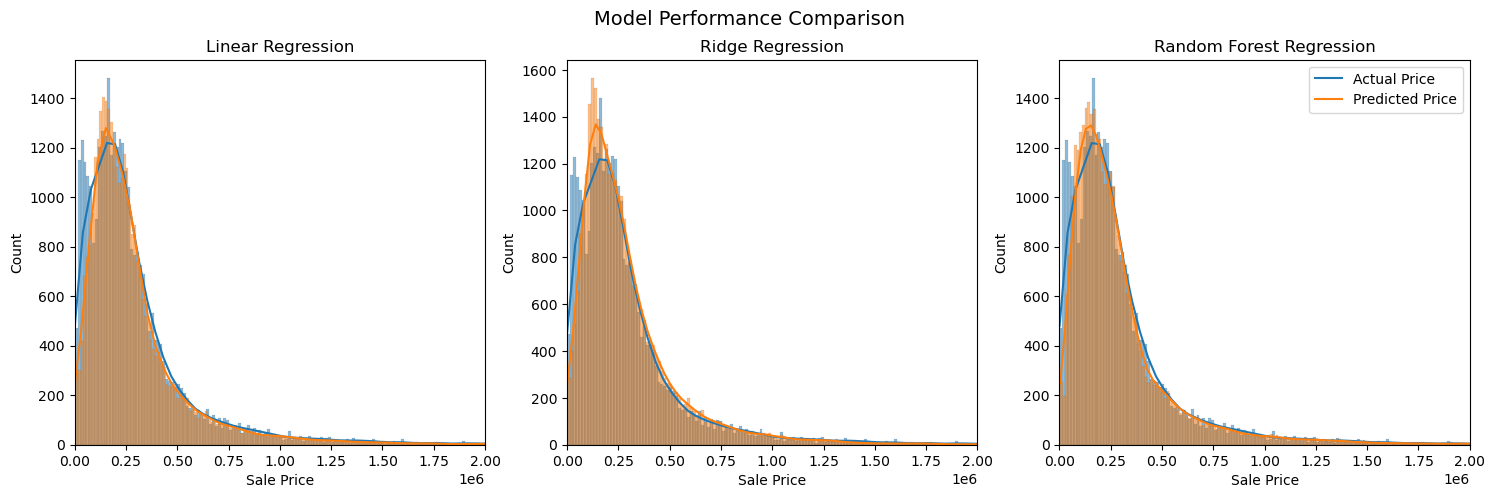

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(y_test, ax=ax[0], kde=True)
sns.histplot(linear_pred, ax=ax[0], kde=True)
sns.histplot(y_test, ax=ax[1], kde=True)
sns.histplot(ridge_pred, ax=ax[1], kde=True)
sns.histplot(y_test, ax=ax[2], kde=True)
sns.histplot(regressor_pred, ax=ax[2], kde=True)
ax[2].legend(['Actual Price','Predicted Price'])
fig.suptitle('Model Performance Comparison', fontsize=14)
ax[0].set_title('Linear Regression')
ax[1].set_title('Ridge Regression')
ax[2].set_title('Random Forest Regression')
ax[0].set_xlim(left=0, right=2000000)
ax[1].set_xlim(left=0, right=2000000)
ax[2].set_xlim(left=0, right=2000000)
plt.show()

We see the models generally udnervalue properties under \\$100K, and overvalue properties between \\$100K and \\$250K, but has a more acccurate prediction for properties over \\$250K. 